In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import os
import math
import spacy
sys.path.append("../")
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dhira.data.data_manager import DataManager
from dhira.data.embedding_manager import EmbeddingManager
from dhira.tf.models.siamese.matching_bilstm import SiameseMatchingBiLSTM

from tqdm import tqdm_notebook as tqdm

nlp = spacy.load('en_core_web_md')

In [4]:
# from dhira.data.dataset.text import IndexedDataset
# from dhira.data.features.pair_feature import PairFeature
# quora_dataset = IndexedDataset(name='quora',
#                                train_files='../data/quora/processed/train_cleaned_train_split.csv',
#                                val_files='../data/quora/processed/train_cleaned_val_split.csv',
#                                test_files='../data/quora/processed/test_final.csv',
#                                feature_type=PairFeature,
#                                pad=True,
#                                pickle_dir='../models/',
#                                max_lengths={"num_sentence_words": 30})

In [5]:
from dhira.data.dataset.quora import QuoraDataset
from dhira.data.features.quora_feature import QuoraFeature
quora_dataset = QuoraDataset(name='quora-spacy',
                               train_files='../data/quora/processed/train_cleaned_train_split.csv',
                               val_files='../data/quora/processed/train_cleaned_val_split.csv',
                               test_files='../data/quora/processed/test_final.csv',
                               feature_type=QuoraFeature,
                               pad=True,
                               pickle_dir='../models/',
                               max_lengths={"num_sentence_words": 30},
                               spacy_nlp_pipeline=nlp)

INFO:dhira.data.dataset.quora:Trying to load prefitted data_indexer... quora-spacy-data_indexr.p
INFO:dhira.data.dataset.quora:Reusing the pickle file quora-spacy-data_indexr.p.


In [6]:
data_manager = DataManager(dataset=quora_dataset)

In [7]:
get_train_data_gen, train_data_size = data_manager.get_train_data_from_file()

INFO:dhira.data.dataset.quora:Getting training data from ../data/quora/processed/train_cleaned_train_split.csv
INFO:dhira.data.dataset.quora:Reusing the pickle file quora-spacy-train.p.
INFO:dhira.data.dataset.quora:Instance max lengths {'num_sentence_words': 271}
INFO:dhira.data.dataset.quora:Padding lengths to length: {'num_sentence_words': 30}


In [8]:
get_val_data_gen, val_data_size = data_manager.get_validation_data_from_file()

INFO:dhira.data.dataset.quora:Getting validation data from ../data/quora/processed/train_cleaned_val_split.csv
INFO:dhira.data.dataset.quora:Reusing the pickle file None.
INFO:dhira.data.dataset.quora:Instance max lengths {'num_sentence_words': 271}
INFO:dhira.data.dataset.quora:Padding lengths to length: {'num_sentence_words': 30}


In [9]:
# embedding_manager = EmbeddingManager(quora_dataset.data_indexer, pickle_dir='../models/')
# embedding_matrix = embedding_manager.get_embedding_matrix(300,'../data/quora/external/glove.6B.300d.txt')
embedding_matrix = EmbeddingManager.get_spacy_embedding_matrix(nlp, quora_dataset.data_indexer)

In [10]:
embedding_matrix.shape

(115170, 300)

In [11]:
model = ''
model = SiameseMatchingBiLSTM(mode='train',
             save_dir='../models/',
             log_dir='../logs/',
             run_id='0',
             word_vocab_size=embedding_matrix.shape[0], 
             word_embedding_dim=300, 
             word_embedding_matrix=embedding_matrix, 
             fine_tune_embeddings=True, 
             share_encoder_weights=True,
             rnn_output_mode='last',
             output_keep_prob=0.5,
             rnn_hidden_size=256)



INFO:dhira.tf.models.base_tf_model:Writing logs to ../logs/SiameseMatchingBiLSTM/00


In [12]:
model.build_graph()

INFO:dhira.tf.models.base_tf_model:Writing params to ../logs/SiameseMatchingBiLSTM/00/trainparams.json
INFO:dhira.tf.models.base_tf_model:Building graph...


In [13]:
batch_size = 64
num_epochs = 1
num_train_steps_per_epoch = int(math.ceil(train_data_size / batch_size))
num_val_steps = int(math.ceil(val_data_size / batch_size))


In [14]:
print('Number of train steps {} and validation steps {} for batch size {}'.format(num_train_steps_per_epoch, 
                                                                                  num_val_steps,
                                                                                  batch_size))

Number of train steps 5686 and validation steps 632 for batch size 64


In [15]:
log_period = 50
val_period = 1000
save_period = 200

In [16]:
model.train(get_train_instance_generator=get_train_data_gen,
            get_val_instance_generator=get_val_data_gen,
            batch_size=batch_size,
            num_train_steps_per_epoch=num_train_steps_per_epoch,
            num_epochs=num_epochs,
            num_val_steps=num_val_steps,
            log_period=log_period,
            val_period=val_period,
            save_period=save_period,
            patience=0)

Writing to /opt/dhira/logs/SiameseMatchingBiLSTM/00

--------------------------------------------------

tensorboard --logdir  /opt/dhira/logs/SiameseMatchingBiLSTM/00

tensorboard --logdir  /opt/dhira/logs/SiameseMatchingBiLSTM/00/checkpoints --port 6007
--------------------------------------------------


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-200


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-400


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-600


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-800


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-1000
INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-1200


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-1400


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-1600


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-1800


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-2000
INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-2200


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-2400


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-2600


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-2800


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-3000
INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-3200


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-3400


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-3600


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-3800


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-4000
INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-4200


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-4400


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-4600


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-4800


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5000
INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5200


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5400


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5600
INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5686


INFO:dhira.tf.models.base_tf_model:Finished 1 epochs!


In [22]:
# get_test_data_gen, test_data_size = data_manager.get_test_data_from_file()

In [28]:
kwargs = {'question_1' : 'How to learn Deep Learning?', 
         'question_2' : 'What are methods to learn deep learning?'}

kwargs = {'question_1' : 'Can I work in Deep Learning?', 
         'question_2' : 'Is it possible to work in Deep Learning?'}

kwargs = {'question_1' : 'Can I work in Deep Learning?', 
         'question_2' : 'What are methods to learn deep learning?'}
single_feature = quora_dataset.custom_input(kwargs=kwargs)

In [29]:
single_feature_batch = DataManager.to_batch(single_feature)

INFO:dhira.data.data_manager:features should be a list of `FeatureBase` type


In [30]:
pred = model.predict_on_single_feature(single_feature_batch, '/opt/dhira/models/SiameseMatchingBiLSTM/00/')

INFO:dhira.tf.models.base_tf_model:Getting latest checkpoint in /opt/dhira/models/SiameseMatchingBiLSTM/00/
INFO:dhira.tf.models.base_tf_model:Attempting to load checkpoint at /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5686


INFO:tensorflow:Restoring parameters from /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5686


INFO:tensorflow:Restoring parameters from /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5686
INFO:dhira.tf.models.base_tf_model:Successfully loaded /opt/dhira/models/SiameseMatchingBiLSTM/00/SiameseMatchingBiLSTM-5686!


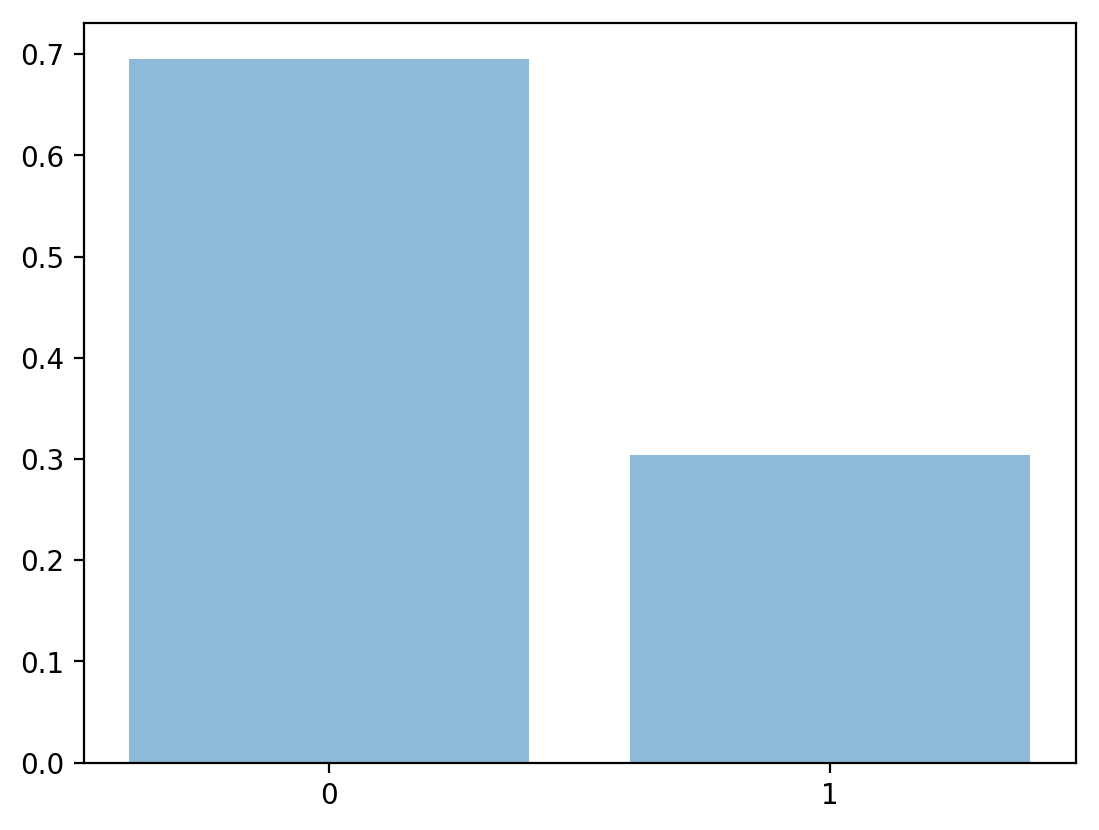

In [31]:
plt.bar([0,1], pred[0], align='center', alpha=0.5)
plt.xticks([0,1], [0,1])
plt.show()